In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import feature_column
from tensorflow.keras import layers

In [17]:
dataframe = pd.read_csv("./ethusd.csv", usecols=[4], names=["price"], skiprows=1)

In [18]:
dataframe.head()

,price
0,2.772120
1,0.753325
2,0.701897
3,0.708448
4,1.067860


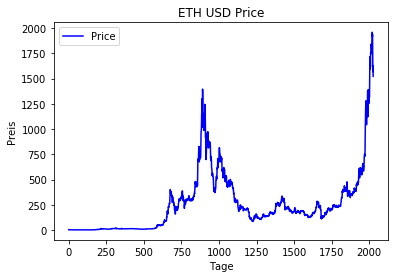

In [21]:
prices = dataframe['price'].to_numpy()

days = range(1, len(prices) + 1)

plt.plot(days, prices, 'blue', label='Price')
plt.title('ETH USD Price')
plt.xlabel('Tage')
plt.ylabel('Preis')
plt.legend()

plt.show()

In [32]:
features = []
labels = []

for i in range(20, len(prices)):
    if (i+1 <= len(prices)-1):
        features.append(prices[i-20:i])
        
        next_price = prices[i]
        
        if (next_price > prices[i+1]):
            labels.append([1])
        else:
            labels.append([-1])
            

In [33]:
for i in range(3):
    print(features[i])
    print(labels[i])

[2.77212  0.753325 0.701897 0.708448 1.06786  1.21744  1.82767  1.82787
 1.6889   1.56603  1.20361  1.08705  1.25886  1.46492  1.39529  1.37923
 1.35259  1.23127  1.14019  1.15998 ]
[-1]
[0.753325 0.701897 0.708448 1.06786  1.21744  1.82767  1.82787  1.6889
 1.56603  1.20361  1.08705  1.25886  1.46492  1.39529  1.37923  1.35259
 1.23127  1.14019  1.15998  1.1477  ]
[1]
[0.701897 0.708448 1.06786  1.21744  1.82767  1.82787  1.6889   1.56603
 1.20361  1.08705  1.25886  1.46492  1.39529  1.37923  1.35259  1.23127
 1.14019  1.15998  1.1477   1.19138 ]
[-1]


In [34]:
def numpy_to_ds(features, labels, batch_size):
    return tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

In [37]:
dataset = numpy_to_ds(features, labels, 16).shuffle(16)

In [38]:
DATASET_SIZE = len(features)

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

train_ds = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = dataset.skip(test_size)
test_dataset = dataset.take(test_size)

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Tweet:", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])